## **Question 1. Semantic Segmentation**

### **Initial Setting**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import os

# Set a fixed seed for reproducibility
seed = 512
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Choose the device based on availability (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters for training
learning_rate = 0.001  # Defines the step size for the optimizer
batch_size = 16  # Number of samples processed before updating the model
num_epochs = 100  # Number of passes through the full dataset
num_classes = 2  # Number of output classes

Using device: cuda


### **Dataset Loading**

In [2]:
file_path = './dataset/oxford-iiit-pet/annotations/trainval.txt'

# Dictionary to store binary values for each category
cat_dog_values = defaultdict(list)

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Split the line into parts and extract the relevant values
        parts = line.strip().split()
        category_value = int(parts[1])
        category_value -= 1  # Adjust category index

        binary_value = int(parts[2])
        cat_dog_values[category_value].append(binary_value)

# Convert the list of binary values to unique values where applicable
for category_value, binary_value in cat_dog_values.items():
    unique_binary_values = list(set(binary_value))
    
    # If only one unique value exists, store that value
    if len(unique_binary_values) == 1:
        cat_dog_values[category_value] = unique_binary_values[0]

# Print the binary values for each category
for category_value, binary_value in cat_dog_values.items():
    print(f"Category {category_value}: binary values = {binary_value}")

Category 0: binary values = 1
Category 1: binary values = 2
Category 2: binary values = 2
Category 3: binary values = 2
Category 4: binary values = 2
Category 5: binary values = 1
Category 6: binary values = 1
Category 7: binary values = 1
Category 8: binary values = 2
Category 9: binary values = 1
Category 10: binary values = 2
Category 11: binary values = 1
Category 12: binary values = 2
Category 13: binary values = 2
Category 14: binary values = 2
Category 15: binary values = 2
Category 16: binary values = 2
Category 17: binary values = 2
Category 18: binary values = 2
Category 19: binary values = 2
Category 20: binary values = 1
Category 21: binary values = 2
Category 22: binary values = 2
Category 23: binary values = 1
Category 24: binary values = 2
Category 25: binary values = 2
Category 26: binary values = 1
Category 27: binary values = 1
Category 28: binary values = 2
Category 29: binary values = 2
Category 30: binary values = 2
Category 31: binary values = 2
Category 32: binar

In [3]:
# Custom transformation function for dataset targets
def target_transform(targets):
    category, mask = targets
    mask = mask_transform(mask)  # Resize the segmentation mask
    mask = np.array(mask)  # Convert mask to numpy array
    return category, torch.tensor(mask, dtype=torch.long)  # Return category and tensor mask

# Function to map species label to category
def species_to_category(label):
    if label in cat_dog_values:
        return cat_dog_values[label]
    else:
        return None
    
# Custom dataset for segmentation tasks, wrapping the original dataset
class CatDogSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)

    # Retrieve item at index and process the label to match category mapping
    def __getitem__(self, idx):
        image, (species_label, mask) = self.dataset[idx]
        cat_dog_label = species_to_category(species_label)
        
        if cat_dog_label is None:
            raise ValueError(f"Invalid label encountered: {species_label}")
        
        # Replace mask values with category label (1 for relevant class, 0 for background)
        mask = torch.where(mask == 1, torch.tensor(cat_dog_label), torch.tensor(0))

        return image, mask

In [4]:
data_dir = './dataset'
os.makedirs(data_dir, exist_ok=True)

# Image transformations applied to input data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()  # Convert image to tensor format
])

# Transformation for segmentation mask (using nearest-neighbor interpolation)
mask_transform = transforms.Resize((256, 256), interpolation=Image.NEAREST)

# Load the OxfordIIITPet dataset for training/validation
dataset = OxfordIIITPet(
    root=data_dir, 
    split='trainval', 
    target_types=('category', 'segmentation'),  # Load both category and segmentation data
    transform=transform,
    target_transform=target_transform, 
    download=True
)

# Load the test dataset
test_dataset = OxfordIIITPet(
    root=data_dir, 
    split='test', 
    target_types=('category', 'segmentation'), 
    transform=transform,
    target_transform=target_transform, 
    download=True
)

# Create instances of the custom dataset
cat_dog_dataset = CatDogSegmentationDataset(dataset)
cat_dog_test_dataset = CatDogSegmentationDataset(test_dataset)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(cat_dog_dataset))
val_size = len(cat_dog_dataset) - train_size
train_dataset, val_dataset = random_split(cat_dog_dataset, [train_size, val_size])

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(cat_dog_test_dataset, batch_size=batch_size, shuffle=False)

Image size: torch.Size([256, 256, 3]) Mask size: torch.Size([256, 256])
Image size: torch.Size([256, 256, 3]) Mask size: torch.Size([256, 256])
Image size: torch.Size([256, 256, 3]) Mask size: torch.Size([256, 256])


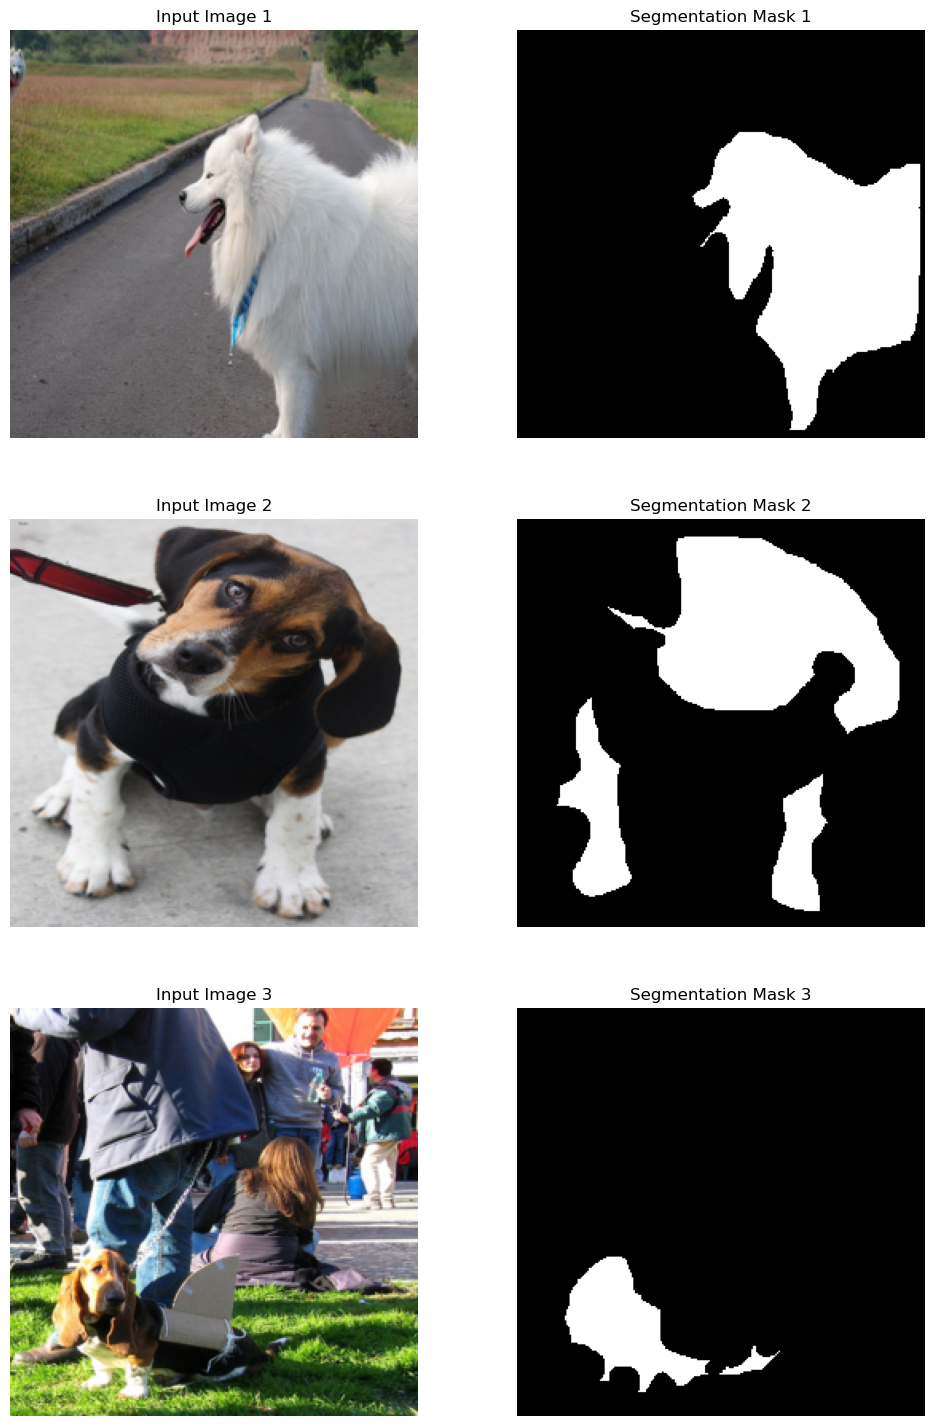

In [5]:
def show_images_from_loader(loader, num_images=5):
    # Get a batch of data from the loader
    data_iter = iter(loader)
    images, masks = next(data_iter)
    
    # Create a subplot grid for displaying images and masks
    fig, ax = plt.subplots(num_images, 2, figsize=(12, 6 * num_images))
    
    for i in range(num_images):
        # Rearrange image dimensions for displaying (channels last)
        image = images[i].permute(1, 2, 0)
        mask = masks[i]
        
        # Print the shape of each image and mask for debugging purposes
        print(f'Image size: {image.shape} Mask size: {mask.shape}')
        
        # Display the image in the left column
        ax[i, 0].imshow(image)
        ax[i, 0].set_title(f"Input Image {i+1}")
        ax[i, 0].axis('off')

        # Display the corresponding segmentation mask in the right column
        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 1].set_title(f"Segmentation Mask {i+1}")
        ax[i, 1].axis('off')
    
    # Show the plot with the images and masks
    plt.show()

# Show 3 image-mask pairs from the train_loader
show_images_from_loader(train_loader, num_images=3)

### **Simple CNN Model**

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes + 1  # Background class is added to the number of output classes
        
        # Encoder: Series of convolutional layers with batch normalization, ReLU activations, and max pooling
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),               
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),              
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),             
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder: Series of transposed convolutional layers for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),              
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),               
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, self.num_classes, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Forward pass through encoder and decoder
        x = self.encoder(x)  # Encode input image into feature maps
        x = self.decoder(x)  # Decode the feature maps back to the original size
        return x

### **UNet Model**

In [7]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes + 1  # Include background as an additional class

        # Define the encoder blocks
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck block
        self.bottleneck = self.conv_block(512, 1024)
        
        # Define the upsampling (decoder) blocks with transposed convolutions
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        # Final output layer: reduce to the number of classes
        self.final_conv = nn.Conv2d(64, self.num_classes, kernel_size=1)

    # Convolutional block: two convolution layers followed by ReLU activations
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder forward pass with max pooling
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoder forward pass: upsample and concatenate with corresponding encoder output
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Final output layer
        return self.final_conv(dec1)

### **Train and Validate Code**

In [8]:
def train_validate_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    model_path, 
    train_loss_list, 
    val_loss_list,
    train_accuracy_list, 
    val_accuracy_list, 
    device
    ):
    
    best_val_loss = float('inf')  # Initialize the best validation loss

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total_pixels = 0

        # Training loop for each batch
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.long().to(device)  # Move data to device (GPU/CPU)
            
            outputs = model(images)  # Forward pass through the model
            loss = criterion(outputs, masks)  # Compute the loss

            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model parameters

            running_loss += loss.item()  # Accumulate the loss

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)  # Get predicted class for each pixel
            correct += (predicted == masks).sum().item()  # Compare with ground truth
            total_pixels += masks.numel()  # Total number of pixels

        # Calculate and store training accuracy and loss
        train_accuracy = 100. * correct / total_pixels  # Training accuracy for the epoch
        train_accuracy_list.append(train_accuracy)  
        train_loss_list.append(running_loss / len(train_loader))  # Average training loss
        
        # Validate the model and store validation loss and accuracy
        avg_val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_loss_list.append(avg_val_loss)
        val_accuracy_list.append(val_accuracy)

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)  # Save model weights
            print(f"Epoch {epoch+1}: Saved best model with validation loss {best_val_loss:.4f} and accuracy {val_accuracy:.2f}%")
        else:
            print(f"Epoch {epoch+1}: validation loss {best_val_loss:.4f} and accuracy {val_accuracy:.2f}%")

In [9]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total_pixels = 0

    # Disable gradient calculation during validation to save memory and computation
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.long().to(device)  # Move data to device (GPU/CPU)

            outputs = model(images)  # Forward pass through the model
            loss = criterion(outputs, masks)  # Compute the loss
            
            val_loss += loss.item()  # Accumulate the validation loss

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)  # Get the predicted class for each pixel
            correct += (predicted == masks).sum().item()  # Compare with ground truth
            total_pixels += masks.numel()  # Total number of pixels

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)  # Average validation loss over all batches
    val_accuracy = 100. * correct / total_pixels  # Validation accuracy (percentage)

    return avg_val_loss, val_accuracy

### **Train and Validate Initial Setting**

In [10]:
# Create a directory to save the models
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

# Define file paths for saving the best models
simple_cnn_model_path = os.path.join(model_dir, 'best_simple_cnn.pth')
unet_model_path = os.path.join(model_dir, 'best_unet.pth')

# Lists to store training and validation metrics for SimpleCNN
train_loss_simple_cnn = []
val_loss_simple_cnn = []
train_accuracy_simple_cnn = []
val_accuracy_simple_cnn = []

# Lists to store training and validation metrics for UNet
train_loss_unet = []
val_loss_unet = []
train_accuracy_unet = []
val_accuracy_unet = []

# Loss function (Cross-Entropy Loss for multi-class segmentation)
criterion = nn.CrossEntropyLoss()

# Initialize the SimpleCNN model and optimizer
simple_cnn = SimpleCNN(num_classes).to(device)  # Move model to the specified device (GPU/CPU)
optimizer_simple_cnn = optim.Adam(simple_cnn.parameters(), lr=learning_rate)  # Use Adam optimizer
best_val_loss_cnn = float('inf')  # Track the best validation loss for SimpleCNN

# Initialize the UNet model and optimizer
unet = UNet(num_classes).to(device)  # Move model to the specified device (GPU/CPU)
optimizer_unet = optim.Adam(unet.parameters(), lr=learning_rate)  # Use Adam optimizer
best_val_loss_unet = float('inf')  # Track the best validation loss for UNet

### **Train and Validate Simple CNN Model**

In [11]:
train_validate_model(
    simple_cnn,  # The model to be trained (SimpleCNN)
    train_loader,  # DataLoader for the training dataset
    val_loader,  # DataLoader for the validation dataset
    criterion,  # Loss function (CrossEntropyLoss)
    optimizer_simple_cnn,  # Optimizer for updating the model (Adam)
    num_epochs,  # Number of training epochs
    simple_cnn_model_path,  # Path to save the best model
    train_loss_simple_cnn,  # List to store training loss for each epoch
    val_loss_simple_cnn,  # List to store validation loss for each epoch
    train_accuracy_simple_cnn,  # List to store training accuracy for each epoch
    val_accuracy_simple_cnn,  # List to store validation accuracy for each epoch
    device  # Device (GPU/CPU) to use for training
)

# Delete the SimpleCNN model from memory to free up GPU resources
del simple_cnn

# Explicitly clear the GPU memory cache to optimize memory usage
torch.cuda.empty_cache()

Epoch 1/100: 100%|██████████| 184/184 [00:57<00:00,  3.20it/s]


Epoch 1: Saved best model with validation loss 0.7237 and accuracy 70.73%


Epoch 2/100: 100%|██████████| 184/184 [00:35<00:00,  5.19it/s]


Epoch 2: Saved best model with validation loss 0.6628 and accuracy 71.66%


Epoch 3/100: 100%|██████████| 184/184 [00:35<00:00,  5.18it/s]


Epoch 3: validation loss 0.6628 and accuracy 60.42%


Epoch 4/100: 100%|██████████| 184/184 [00:35<00:00,  5.21it/s]


Epoch 4: Saved best model with validation loss 0.6268 and accuracy 73.65%


Epoch 5/100: 100%|██████████| 184/184 [00:35<00:00,  5.21it/s]


Epoch 5: Saved best model with validation loss 0.6135 and accuracy 75.07%


Epoch 6/100: 100%|██████████| 184/184 [00:31<00:00,  5.83it/s]


Epoch 6: Saved best model with validation loss 0.5847 and accuracy 75.39%


Epoch 7/100: 100%|██████████| 184/184 [00:31<00:00,  5.91it/s]


Epoch 7: validation loss 0.5847 and accuracy 74.21%


Epoch 8/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 8: Saved best model with validation loss 0.5744 and accuracy 75.89%


Epoch 9/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 9: validation loss 0.5744 and accuracy 75.08%


Epoch 10/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 10: validation loss 0.5744 and accuracy 74.20%


Epoch 11/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 11: validation loss 0.5744 and accuracy 74.77%


Epoch 12/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 12: Saved best model with validation loss 0.5501 and accuracy 77.17%


Epoch 13/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 13: Saved best model with validation loss 0.5377 and accuracy 77.33%


Epoch 14/100: 100%|██████████| 184/184 [00:31<00:00,  5.91it/s]


Epoch 14: validation loss 0.5377 and accuracy 76.75%


Epoch 15/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 15: validation loss 0.5377 and accuracy 76.26%


Epoch 16/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 16: validation loss 0.5377 and accuracy 77.24%


Epoch 17/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 17: validation loss 0.5377 and accuracy 75.61%


Epoch 18/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 18: validation loss 0.5377 and accuracy 69.46%


Epoch 19/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 19: Saved best model with validation loss 0.5318 and accuracy 77.87%


Epoch 20/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 20: validation loss 0.5318 and accuracy 74.32%


Epoch 21/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 21: validation loss 0.5318 and accuracy 75.37%


Epoch 22/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 22: validation loss 0.5318 and accuracy 73.74%


Epoch 23/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 23: validation loss 0.5318 and accuracy 77.33%


Epoch 24/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 24: validation loss 0.5318 and accuracy 75.96%


Epoch 25/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 25: Saved best model with validation loss 0.5205 and accuracy 78.26%


Epoch 26/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 26: validation loss 0.5205 and accuracy 76.49%


Epoch 27/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 27: Saved best model with validation loss 0.5070 and accuracy 78.65%


Epoch 28/100: 100%|██████████| 184/184 [00:31<00:00,  5.91it/s]


Epoch 28: validation loss 0.5070 and accuracy 78.07%


Epoch 29/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 29: validation loss 0.5070 and accuracy 76.27%


Epoch 30/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 30: validation loss 0.5070 and accuracy 77.29%


Epoch 31/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 31: validation loss 0.5070 and accuracy 78.02%


Epoch 32/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 32: validation loss 0.5070 and accuracy 76.24%


Epoch 33/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 33: validation loss 0.5070 and accuracy 78.66%


Epoch 34/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 34: validation loss 0.5070 and accuracy 77.30%


Epoch 35/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 35: validation loss 0.5070 and accuracy 76.40%


Epoch 36/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 36: validation loss 0.5070 and accuracy 77.94%


Epoch 37/100: 100%|██████████| 184/184 [00:31<00:00,  5.92it/s]


Epoch 37: Saved best model with validation loss 0.5068 and accuracy 78.52%


Epoch 38/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 38: validation loss 0.5068 and accuracy 78.76%


Epoch 39/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 39: validation loss 0.5068 and accuracy 77.36%


Epoch 40/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 40: validation loss 0.5068 and accuracy 77.97%


Epoch 41/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 41: validation loss 0.5068 and accuracy 79.10%


Epoch 42/100: 100%|██████████| 184/184 [00:31<00:00,  5.92it/s]


Epoch 42: validation loss 0.5068 and accuracy 78.66%


Epoch 43/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 43: Saved best model with validation loss 0.4921 and accuracy 79.58%


Epoch 44/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 44: validation loss 0.4921 and accuracy 79.08%


Epoch 45/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 45: validation loss 0.4921 and accuracy 76.92%


Epoch 46/100: 100%|██████████| 184/184 [00:30<00:00,  5.98it/s]


Epoch 46: validation loss 0.4921 and accuracy 79.39%


Epoch 47/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 47: validation loss 0.4921 and accuracy 79.18%


Epoch 48/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 48: validation loss 0.4921 and accuracy 74.93%


Epoch 49/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 49: validation loss 0.4921 and accuracy 79.00%


Epoch 50/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 50: validation loss 0.4921 and accuracy 78.75%


Epoch 51/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 51: validation loss 0.4921 and accuracy 79.31%


Epoch 52/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 52: Saved best model with validation loss 0.4859 and accuracy 79.74%


Epoch 53/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 53: validation loss 0.4859 and accuracy 79.47%


Epoch 54/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 54: validation loss 0.4859 and accuracy 78.67%


Epoch 55/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 55: validation loss 0.4859 and accuracy 78.31%


Epoch 56/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 56: validation loss 0.4859 and accuracy 79.26%


Epoch 57/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 57: validation loss 0.4859 and accuracy 79.55%


Epoch 58/100: 100%|██████████| 184/184 [00:30<00:00,  5.98it/s]


Epoch 58: Saved best model with validation loss 0.4782 and accuracy 80.23%


Epoch 59/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 59: validation loss 0.4782 and accuracy 79.42%


Epoch 60/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 60: validation loss 0.4782 and accuracy 80.09%


Epoch 61/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 61: validation loss 0.4782 and accuracy 77.03%


Epoch 62/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 62: Saved best model with validation loss 0.4746 and accuracy 80.15%


Epoch 63/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 63: validation loss 0.4746 and accuracy 79.82%


Epoch 64/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 64: validation loss 0.4746 and accuracy 78.23%


Epoch 65/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 65: validation loss 0.4746 and accuracy 76.17%


Epoch 66/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 66: validation loss 0.4746 and accuracy 80.13%


Epoch 67/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 67: validation loss 0.4746 and accuracy 79.66%


Epoch 68/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 68: validation loss 0.4746 and accuracy 79.33%


Epoch 69/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 69: validation loss 0.4746 and accuracy 79.71%


Epoch 70/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 70: validation loss 0.4746 and accuracy 73.21%


Epoch 71/100: 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


Epoch 71: validation loss 0.4746 and accuracy 80.26%


Epoch 72/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 72: validation loss 0.4746 and accuracy 78.34%


Epoch 73/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 73: validation loss 0.4746 and accuracy 80.23%


Epoch 74/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 74: validation loss 0.4746 and accuracy 79.49%


Epoch 75/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 75: validation loss 0.4746 and accuracy 79.84%


Epoch 76/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 76: validation loss 0.4746 and accuracy 79.93%


Epoch 77/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 77: validation loss 0.4746 and accuracy 80.14%


Epoch 78/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 78: validation loss 0.4746 and accuracy 79.88%


Epoch 79/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 79: validation loss 0.4746 and accuracy 78.26%


Epoch 80/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 80: validation loss 0.4746 and accuracy 77.78%


Epoch 81/100: 100%|██████████| 184/184 [00:31<00:00,  5.94it/s]


Epoch 81: validation loss 0.4746 and accuracy 78.03%


Epoch 82/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 82: validation loss 0.4746 and accuracy 78.81%


Epoch 83/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 83: validation loss 0.4746 and accuracy 78.24%


Epoch 84/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 84: validation loss 0.4746 and accuracy 78.52%


Epoch 85/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 85: validation loss 0.4746 and accuracy 78.91%


Epoch 86/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 86: validation loss 0.4746 and accuracy 79.77%


Epoch 87/100: 100%|██████████| 184/184 [00:31<00:00,  5.93it/s]


Epoch 87: validation loss 0.4746 and accuracy 79.97%


Epoch 88/100: 100%|██████████| 184/184 [00:31<00:00,  5.91it/s]


Epoch 88: validation loss 0.4746 and accuracy 79.73%


Epoch 89/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 89: validation loss 0.4746 and accuracy 79.25%


Epoch 90/100: 100%|██████████| 184/184 [00:30<00:00,  5.94it/s]


Epoch 90: validation loss 0.4746 and accuracy 78.08%


Epoch 91/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 91: validation loss 0.4746 and accuracy 79.64%


Epoch 92/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 92: validation loss 0.4746 and accuracy 79.90%


Epoch 93/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 93: Saved best model with validation loss 0.4746 and accuracy 80.31%


Epoch 94/100: 100%|██████████| 184/184 [00:31<00:00,  5.92it/s]


Epoch 94: validation loss 0.4746 and accuracy 79.33%


Epoch 95/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 95: validation loss 0.4746 and accuracy 79.71%


Epoch 96/100: 100%|██████████| 184/184 [00:30<00:00,  5.95it/s]


Epoch 96: validation loss 0.4746 and accuracy 80.09%


Epoch 97/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 97: Saved best model with validation loss 0.4663 and accuracy 80.73%


Epoch 98/100: 100%|██████████| 184/184 [00:30<00:00,  5.96it/s]


Epoch 98: validation loss 0.4663 and accuracy 78.82%


Epoch 99/100: 100%|██████████| 184/184 [00:31<00:00,  5.84it/s]


Epoch 99: validation loss 0.4663 and accuracy 79.79%


Epoch 100/100: 100%|██████████| 184/184 [00:31<00:00,  5.82it/s]


Epoch 100: validation loss 0.4663 and accuracy 80.08%


### **Train and Validate UNet Model**

In [12]:
train_validate_model(
    unet,  # The UNet model to be trained
    train_loader,  # DataLoader for the training dataset
    val_loader,  # DataLoader for the validation dataset
    criterion,  # Loss function (CrossEntropyLoss)
    optimizer_unet,  # Optimizer for UNet (Adam)
    num_epochs,  # Number of training epochs
    unet_model_path,  # Path to save the best UNet model
    train_loss_unet,  # List to store training loss for each epoch
    val_loss_unet,  # List to store validation loss for each epoch
    train_accuracy_unet,  # List to store training accuracy for each epoch
    val_accuracy_unet,  # List to store validation accuracy for each epoch
    device  # Device (GPU/CPU) to use for training
)

# Delete the UNet model from memory to free up GPU resources
del unet

# Explicitly clear the GPU memory cache to optimize memory usage
torch.cuda.empty_cache()

Epoch 1/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 1: Saved best model with validation loss 0.7319 and accuracy 70.73%


Epoch 2/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 2: Saved best model with validation loss 0.7176 and accuracy 70.73%


Epoch 3/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 3: Saved best model with validation loss 0.6398 and accuracy 70.73%


Epoch 4/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 4: Saved best model with validation loss 0.6089 and accuracy 75.19%


Epoch 5/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 5: Saved best model with validation loss 0.5989 and accuracy 75.45%


Epoch 6/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 6: Saved best model with validation loss 0.5958 and accuracy 75.88%


Epoch 7/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 7: Saved best model with validation loss 0.5777 and accuracy 76.66%


Epoch 8/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 8: Saved best model with validation loss 0.5677 and accuracy 77.17%


Epoch 9/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 9: Saved best model with validation loss 0.5592 and accuracy 77.95%


Epoch 10/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 10: Saved best model with validation loss 0.5418 and accuracy 77.80%


Epoch 11/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 11: Saved best model with validation loss 0.4954 and accuracy 79.59%


Epoch 12/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 12: Saved best model with validation loss 0.4826 and accuracy 80.38%


Epoch 13/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 13: Saved best model with validation loss 0.4633 and accuracy 80.71%


Epoch 14/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 14: Saved best model with validation loss 0.4575 and accuracy 81.13%


Epoch 15/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 15: Saved best model with validation loss 0.4483 and accuracy 81.24%


Epoch 16/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 16: Saved best model with validation loss 0.4267 and accuracy 81.98%


Epoch 17/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 17: validation loss 0.4267 and accuracy 81.24%


Epoch 18/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 18: Saved best model with validation loss 0.4257 and accuracy 81.96%


Epoch 19/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 19: Saved best model with validation loss 0.4126 and accuracy 82.37%


Epoch 20/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 20: validation loss 0.4126 and accuracy 81.92%


Epoch 21/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 21: Saved best model with validation loss 0.4001 and accuracy 82.68%


Epoch 22/100: 100%|██████████| 184/184 [02:00<00:00,  1.53it/s]


Epoch 22: validation loss 0.4001 and accuracy 83.06%


Epoch 23/100: 100%|██████████| 184/184 [02:05<00:00,  1.46it/s]


Epoch 23: validation loss 0.4001 and accuracy 83.18%


Epoch 24/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 24: Saved best model with validation loss 0.3880 and accuracy 84.39%


Epoch 25/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 25: validation loss 0.3880 and accuracy 83.91%


Epoch 26/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 26: validation loss 0.3880 and accuracy 85.27%


Epoch 27/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 27: validation loss 0.3880 and accuracy 85.18%


Epoch 28/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 28: validation loss 0.3880 and accuracy 84.91%


Epoch 29/100: 100%|██████████| 184/184 [01:54<00:00,  1.61it/s]


Epoch 29: validation loss 0.3880 and accuracy 84.88%


Epoch 30/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 30: validation loss 0.3880 and accuracy 85.68%


Epoch 31/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 31: validation loss 0.3880 and accuracy 86.15%


Epoch 32/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 32: validation loss 0.3880 and accuracy 86.56%


Epoch 33/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 33: validation loss 0.3880 and accuracy 85.62%


Epoch 34/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 34: validation loss 0.3880 and accuracy 86.26%


Epoch 35/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 35: validation loss 0.3880 and accuracy 86.21%


Epoch 36/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 36: validation loss 0.3880 and accuracy 85.95%


Epoch 37/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 37: validation loss 0.3880 and accuracy 85.74%


Epoch 38/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 38: validation loss 0.3880 and accuracy 86.71%


Epoch 39/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 39: validation loss 0.3880 and accuracy 86.67%


Epoch 40/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 40: validation loss 0.3880 and accuracy 86.39%


Epoch 41/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 41: validation loss 0.3880 and accuracy 86.87%


Epoch 42/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 42: validation loss 0.3880 and accuracy 86.58%


Epoch 43/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 43: validation loss 0.3880 and accuracy 86.03%


Epoch 44/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 44: validation loss 0.3880 and accuracy 85.81%


Epoch 45/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 45: validation loss 0.3880 and accuracy 86.27%


Epoch 46/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 46: validation loss 0.3880 and accuracy 86.61%


Epoch 47/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 47: validation loss 0.3880 and accuracy 86.75%


Epoch 48/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 48: validation loss 0.3880 and accuracy 86.62%


Epoch 49/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 49: validation loss 0.3880 and accuracy 86.71%


Epoch 50/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 50: validation loss 0.3880 and accuracy 86.67%


Epoch 51/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 51: validation loss 0.3880 and accuracy 86.54%


Epoch 52/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 52: validation loss 0.3880 and accuracy 86.53%


Epoch 53/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 53: validation loss 0.3880 and accuracy 86.70%


Epoch 54/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 54: validation loss 0.3880 and accuracy 86.37%


Epoch 55/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 55: validation loss 0.3880 and accuracy 86.60%


Epoch 56/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 56: validation loss 0.3880 and accuracy 84.47%


Epoch 57/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 57: validation loss 0.3880 and accuracy 85.69%


Epoch 58/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 58: validation loss 0.3880 and accuracy 86.38%


Epoch 59/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 59: validation loss 0.3880 and accuracy 86.83%


Epoch 60/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 60: validation loss 0.3880 and accuracy 86.80%


Epoch 61/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 61: validation loss 0.3880 and accuracy 86.83%


Epoch 62/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 62: validation loss 0.3880 and accuracy 86.80%


Epoch 63/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 63: validation loss 0.3880 and accuracy 86.80%


Epoch 64/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 64: validation loss 0.3880 and accuracy 86.81%


Epoch 65/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 65: validation loss 0.3880 and accuracy 86.70%


Epoch 66/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 66: validation loss 0.3880 and accuracy 86.73%


Epoch 67/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 67: validation loss 0.3880 and accuracy 86.80%


Epoch 68/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 68: validation loss 0.3880 and accuracy 86.74%


Epoch 69/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 69: validation loss 0.3880 and accuracy 86.76%


Epoch 70/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 70: validation loss 0.3880 and accuracy 86.71%


Epoch 71/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 71: validation loss 0.3880 and accuracy 85.18%


Epoch 72/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 72: validation loss 0.3880 and accuracy 86.15%


Epoch 73/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 73: validation loss 0.3880 and accuracy 86.58%


Epoch 74/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 74: validation loss 0.3880 and accuracy 86.82%


Epoch 75/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 75: validation loss 0.3880 and accuracy 86.89%


Epoch 76/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 76: validation loss 0.3880 and accuracy 86.80%


Epoch 77/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 77: validation loss 0.3880 and accuracy 86.83%


Epoch 78/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 78: validation loss 0.3880 and accuracy 86.78%


Epoch 79/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 79: validation loss 0.3880 and accuracy 86.91%


Epoch 80/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 80: validation loss 0.3880 and accuracy 86.83%


Epoch 81/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 81: validation loss 0.3880 and accuracy 86.84%


Epoch 82/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 82: validation loss 0.3880 and accuracy 86.71%


Epoch 83/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 83: validation loss 0.3880 and accuracy 86.79%


Epoch 84/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 84: validation loss 0.3880 and accuracy 86.90%


Epoch 85/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 85: validation loss 0.3880 and accuracy 86.68%


Epoch 86/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 86: validation loss 0.3880 and accuracy 86.79%


Epoch 87/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 87: validation loss 0.3880 and accuracy 86.53%


Epoch 88/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 88: validation loss 0.3880 and accuracy 86.35%


Epoch 89/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 89: validation loss 0.3880 and accuracy 85.67%


Epoch 90/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 90: validation loss 0.3880 and accuracy 86.44%


Epoch 91/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 91: validation loss 0.3880 and accuracy 86.76%


Epoch 92/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 92: validation loss 0.3880 and accuracy 86.83%


Epoch 93/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 93: validation loss 0.3880 and accuracy 87.02%


Epoch 94/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 94: validation loss 0.3880 and accuracy 86.94%


Epoch 95/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 95: validation loss 0.3880 and accuracy 86.95%


Epoch 96/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 96: validation loss 0.3880 and accuracy 86.91%


Epoch 97/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 97: validation loss 0.3880 and accuracy 86.94%


Epoch 98/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 98: validation loss 0.3880 and accuracy 86.95%


Epoch 99/100: 100%|██████████| 184/184 [01:53<00:00,  1.63it/s]


Epoch 99: validation loss 0.3880 and accuracy 86.89%


Epoch 100/100: 100%|██████████| 184/184 [01:53<00:00,  1.62it/s]


Epoch 100: validation loss 0.3880 and accuracy 86.84%


### **Test Code**

In [13]:
def test_model(model, test_loader, criterion, device, num_visualizations=3):
    model.eval()  # Set the model to evaluation mode (disables dropout/batchnorm)
    test_loss = 0.0
    correct = 0
    total_pixels = 0
    visualizations_done = 0  # Counter for how many visualizations have been done
    
    # Disable gradient calculation to save memory during evaluation
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.long().to(device)  # Move data to GPU/CPU

            outputs = model(images)  # Forward pass through the model
            loss = criterion(outputs, masks)  # Calculate loss
            
            test_loss += loss.item()  # Accumulate test loss

            _, predicted = torch.max(outputs, 1)  # Get predicted class for each pixel
            
            correct += (predicted == masks).sum().item()  # Count correct pixel predictions
            total_pixels += masks.numel()  # Update total number of pixels

            # Limit the number of visualizations to num_visualizations
            if visualizations_done < num_visualizations:
                # Move tensors to CPU and convert to numpy
                images_np = images[0].cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
                masks_np = masks[0].cpu().numpy()  # Ground truth mask
                predicted_np = predicted[0].cpu().numpy()  # Predicted mask

                # Call the visualization function to display results
                visualize_segmentation(images_np, masks_np, predicted_np)
                visualizations_done += 1

    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total_pixels  # Pixel-wise accuracy
    
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


def visualize_segmentation(image, true_mask, predicted_mask):
    """Visualize the input image, ground truth mask, and predicted mask."""
    plt.figure(figsize=(12, 6))

    # Visualize the original image
    plt.subplot(1, 3, 1)
    plt.imshow(np.clip(image, 0, 1))  # Clip image values between [0, 1] for display
    plt.title('Original Image')

    # Visualize the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')  # Ground truth mask
    plt.title('True Mask')

    # Visualize the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')  # Predicted mask
    plt.title('Predicted Mask')

    plt.show()

### **Test Initial Setting**

In [14]:
# Initialize SimpleCNN and load the saved best model weights
simple_cnn = SimpleCNN(num_classes).to(device)
simple_cnn.load_state_dict(torch.load(simple_cnn_model_path, weights_only=True))  # Load the pre-trained weights

# Initialize UNet and load the saved best model weights
unet = UNet(num_classes).to(device)
unet.load_state_dict(torch.load(unet_model_path, weights_only=True))  # Load the pre-trained weights

<All keys matched successfully>

### **Test Simple CNN Model**

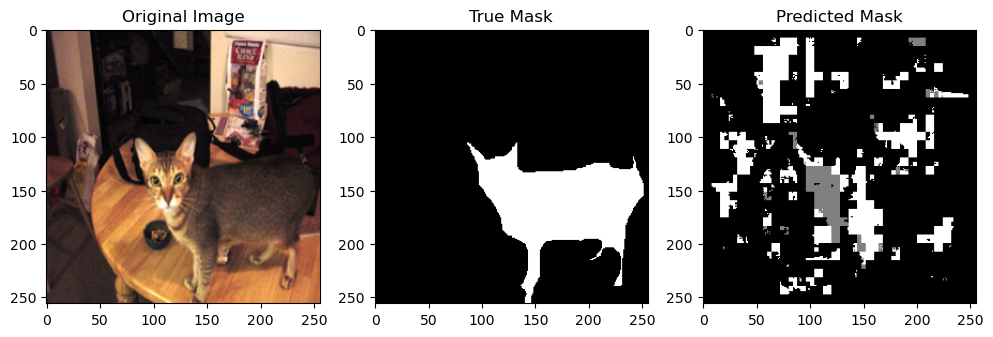

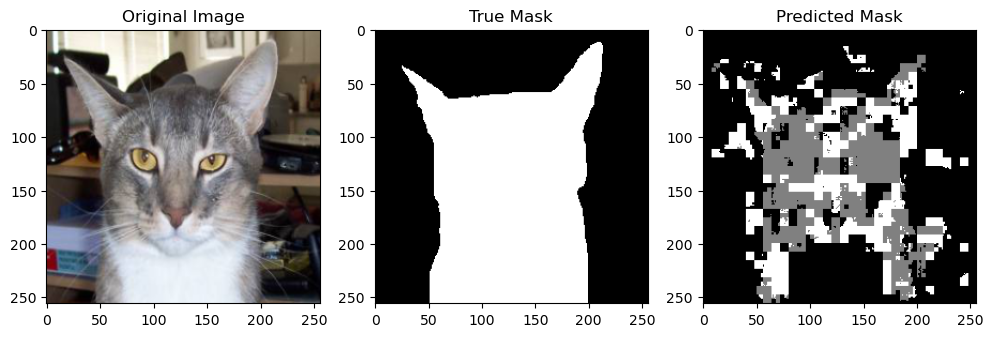

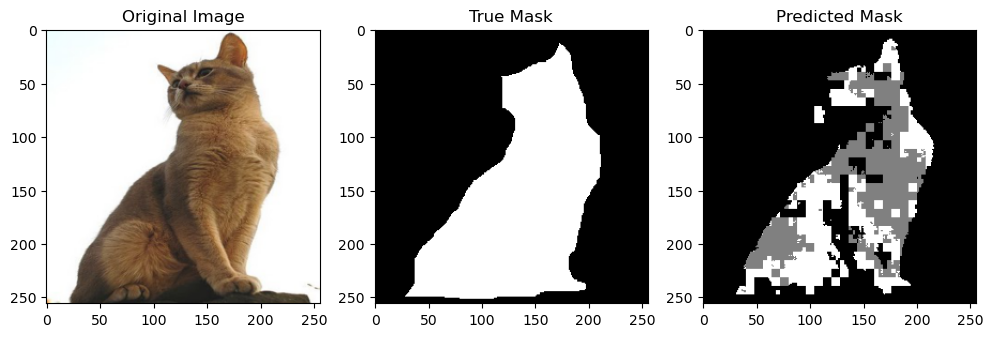

Test Loss: 0.4786, Test Accuracy: 80.09%


In [15]:
# Test the SimpleCNN model on the test dataset
test_model(simple_cnn, test_loader, criterion, device)

### **Test UNet Model**

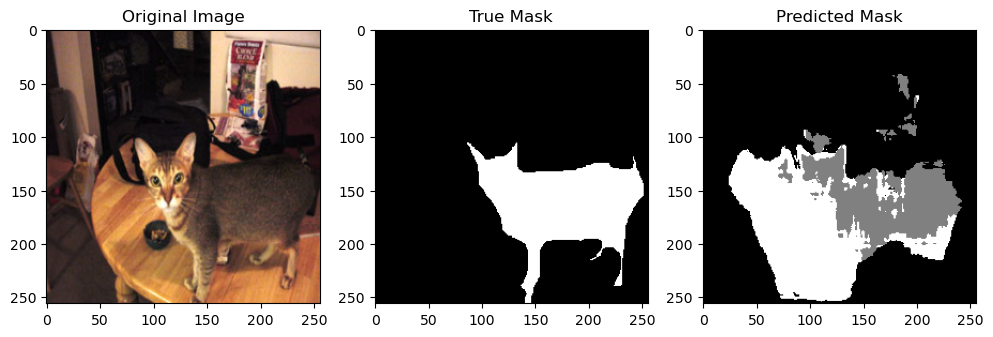

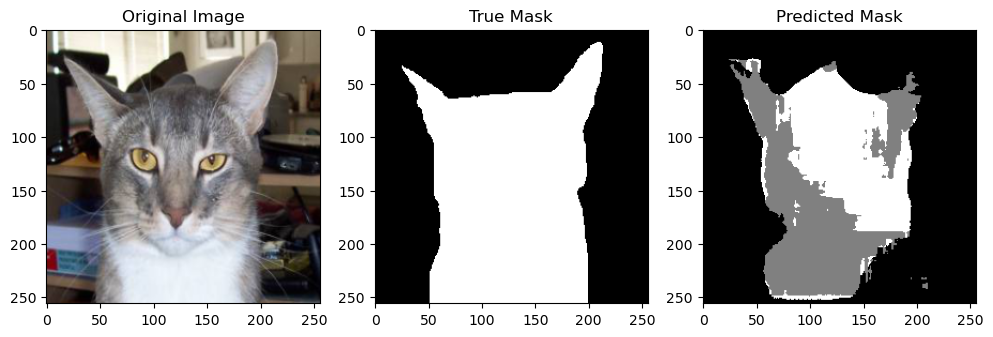

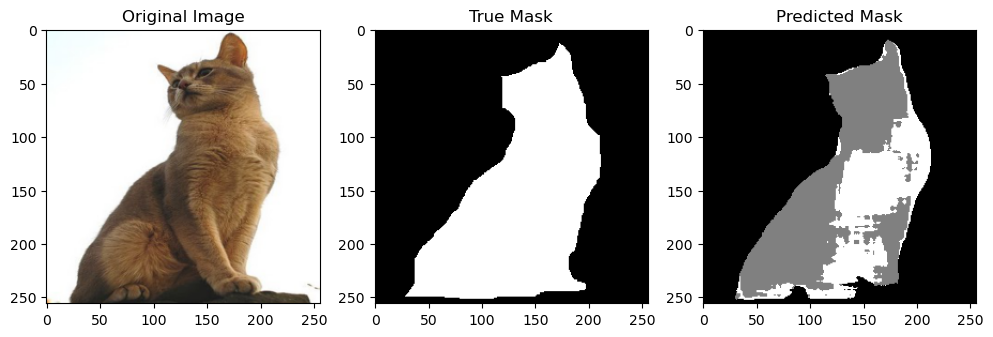

Test Loss: 0.4010, Test Accuracy: 83.87%


In [16]:
# Test the UNet model on the test dataset
test_model(unet, test_loader, criterion, device)

### **Save Log to CSV File**

In [17]:
# Create a dictionary with the lists of losses and accuracies for both SimpleCNN and UNet
data = {
    'train_loss_simple_cnn': train_loss_simple_cnn,  # Training loss for SimpleCNN
    'val_loss_simple_cnn': val_loss_simple_cnn,      # Validation loss for SimpleCNN
    'train_accuracy_simple_cnn': train_accuracy_simple_cnn,  # Training accuracy for SimpleCNN
    'val_accuracy_simple_cnn': val_accuracy_simple_cnn,      # Validation accuracy for SimpleCNN
    'train_loss_unet': train_loss_unet,              # Training loss for UNet
    'val_loss_unet': val_loss_unet,                  # Validation loss for UNet
    'train_accuracy_unet': train_accuracy_unet,      # Training accuracy for UNet
    'val_accuracy_unet': val_accuracy_unet           # Validation accuracy for UNet
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Define the directory and path to save the CSV file
log_dir = './log'
os.makedirs(log_dir, exist_ok=True)  # Create the directory if it doesn't exist
log_path = os.path.join(log_dir, 'loss_accuracy_data.csv')

# Save the DataFrame to a CSV file without the index column
df.to_csv(log_path, index=False)

print("Saved as CSV file.")

Saved as CSV file.


### **Evaluate and Plot the Results**

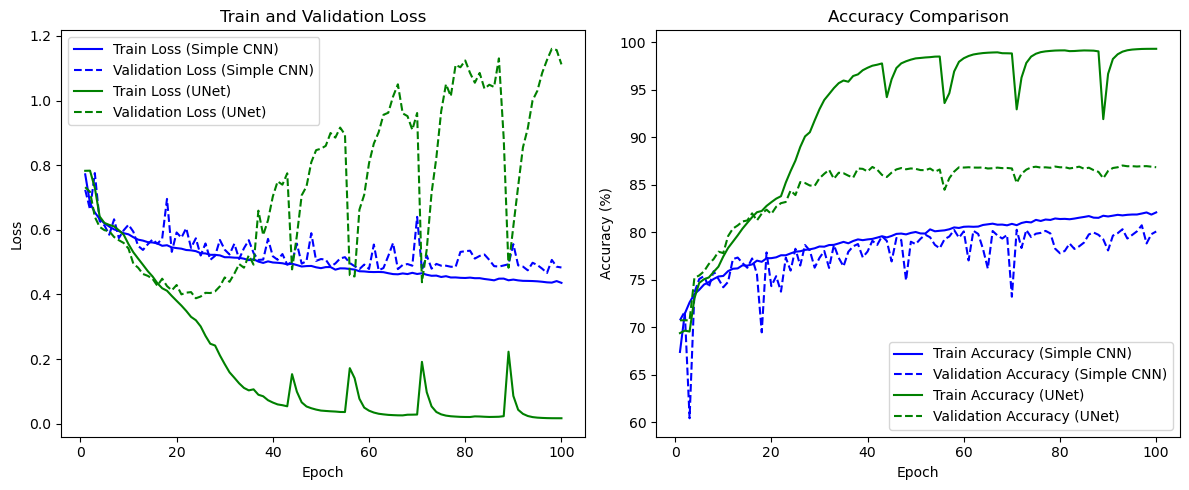

In [18]:
# Load the CSV file into a DataFrame
load_df = pd.read_csv(log_path)

# Extract values from the DataFrame into lists for each metric
train_loss_simple_cnn = load_df['train_loss_simple_cnn'].tolist()
val_loss_simple_cnn = load_df['val_loss_simple_cnn'].tolist()
train_accuracy_simple_cnn = load_df['train_accuracy_simple_cnn'].tolist()
val_accuracy_simple_cnn = load_df['val_accuracy_simple_cnn'].tolist()

train_loss_unet = load_df['train_loss_unet'].tolist()
val_loss_unet = load_df['val_loss_unet'].tolist()
train_accuracy_unet = load_df['train_accuracy_unet'].tolist()
val_accuracy_unet = load_df['val_accuracy_unet'].tolist()

# Determine the number of epochs from the length of one of the lists
num_epochs = len(train_loss_simple_cnn)

# Plotting setup: Create a figure for the plots
plt.figure(figsize=(12, 5))

# Plot 1: Train and validation loss for both SimpleCNN and UNet
plt.subplot(1, 2, 1)  # Create the first subplot
plt.plot(range(1, num_epochs + 1), train_loss_simple_cnn, 'b-', label='Train Loss (Simple CNN)')  # SimpleCNN train loss
plt.plot(range(1, num_epochs + 1), val_loss_simple_cnn, 'b--', label='Validation Loss (Simple CNN)')  # SimpleCNN val loss
plt.plot(range(1, num_epochs + 1), train_loss_unet, 'g-', label='Train Loss (UNet)')  # UNet train loss
plt.plot(range(1, num_epochs + 1), val_loss_unet, 'g--', label='Validation Loss (UNet)')  # UNet val loss
plt.xlabel('Epoch')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis
plt.title('Train and Validation Loss')  # Title for the plot
plt.legend()  # Display the legend

# Plot 2: Train and validation accuracy for both SimpleCNN and UNet
plt.subplot(1, 2, 2)  # Create the second subplot
plt.plot(range(1, num_epochs + 1), train_accuracy_simple_cnn, 'b-', label='Train Accuracy (Simple CNN)')  # SimpleCNN train accuracy
plt.plot(range(1, num_epochs + 1), val_accuracy_simple_cnn, 'b--', label='Validation Accuracy (Simple CNN)')  # SimpleCNN val accuracy
plt.plot(range(1, num_epochs + 1), train_accuracy_unet, 'g-', label='Train Accuracy (UNet)')  # UNet train accuracy
plt.plot(range(1, num_epochs + 1), val_accuracy_unet, 'g--', label='Validation Accuracy (UNet)')  # UNet val accuracy
plt.xlabel('Epoch')  # Label for x-axis
plt.ylabel('Accuracy (%)')  # Label for y-axis
plt.title('Accuracy Comparison')  # Title for the plot
plt.legend()  # Display the legend

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()